# IMPORT

In [2]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"]="1"

tf.debugging.set_log_device_placement(True)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# IMAGE READ & PREPROCESS

In [2]:
folder = './IDC_regular_ps50_idx5/'
folders = [folder + x for x in sorted(os.listdir(folder))]
folders_0 = list(pd.Series(folders)+'/0/')
folders_1 = list(pd.Series(folders)+'/1/')

In [3]:
images_path = []
images_0=[]
images_1=[]

In [4]:
for i in range(0,len(folders_0)):
    images_0.extend([folders_0[i] + x for x in sorted(os.listdir(folders_0[i]))])
    images_1.extend([folders_1[i] + x for x in sorted(os.listdir(folders_1[i]))])
    
print(len(images_0))
print(len(images_1))

198738
78786


In [5]:
images_path = np.hstack([images_1,np.random.choice(images_0, len(images_1))])

In [6]:
id_num = []
path = []
name = []
result = []

for i in images_path:
    split=i.split("/")
    id_num.append(split[-3])
    path.append(i)
    name.append(split[-1])
    result.append(split[-2])

In [7]:
data = pd.DataFrame({"id_num":id_num, "path":path, "name":name, "result":result})

In [8]:
data["result"].value_counts()

0    78786
1    78786
Name: result, dtype: int64

In [9]:
X=data.iloc[:, :3]

y=data.iloc[:, 3].values

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=5)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state=5)

In [12]:
train_data = X_train
train_data['label'] = y_train

test_data = X_test
test_data['label'] = y_test

val_data = X_val
val_data['label'] = y_val

C:\ai\python\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ai\python\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\ai\python\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [4]:
IM_WIDTH = 50
IM_HEIGHT = 50

In [14]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=180, width_shift_range=0.2,
                                   height_shift_range=0.2, horizontal_flip=True, vertical_flip=True)

train_generator = train_datagen.flow_from_dataframe(train_data, x_col="path", y_col="label", shuffle=True,
                                                  batch_size=50, class_mode="binary", target_size=(IM_WIDTH, IM_HEIGHT))

Found 141814 validated image filenames belonging to 2 classes.


In [15]:
train_generator.n

141814

In [16]:
test_datagen = ImageDataGenerator(rescale=1./255, rotation_range=180, width_shift_range=0.2,
                                height_shift_range=0.2, horizontal_flip=True, vertical_flip=True)

test_generator = test_datagen.flow_from_dataframe(test_data, x_col="path", y_col="label", shuffle=True,
                                                  batch_size=50, class_mode="binary", target_size=(IM_WIDTH, IM_HEIGHT))

Found 15758 validated image filenames belonging to 2 classes.


In [17]:
test_generator.n

15758

In [18]:
val_datagen=ImageDataGenerator(rescale=1./255, rotation_range=180, width_shift_range=0.2,
                                height_shift_range=0.2, horizontal_flip=True, vertical_flip=True)

val_generator=val_datagen.flow_from_dataframe(val_data, x_col="path", y_col="label", shuffle=True,
                                                  batch_size=50, class_mode="binary", target_size=(IM_WIDTH, IM_HEIGHT))

Found 15758 validated image filenames belonging to 2 classes.


In [19]:
val_generator.n

15758

In [20]:
img, label = train_generator.next()

img.shape

(50, 50, 50, 3)

In [21]:
label

array([1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0.,
       0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1.],
      dtype=float32)

In [22]:
label = label.reshape(-1,1)

In [23]:
enc = OneHotEncoder()
enc.fit(label)

label_onehot = enc.transform(label).toarray()
label_onehot = np.array(label_onehot, dtype="float32")
label_onehot

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

# MODEL (MobileNetV2)

In [5]:
mobV2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IM_WIDTH, IM_HEIGHT, 3))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


C:\ai\python\anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1080, pci bus id: 0000:0b:00.0, compute capability: 6.1



In [7]:
mobV2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 50, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 51, 51, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 25, 25, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 25, 25, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [25]:
model = Sequential()
model.add(mobV2)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 2, 2, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 5120)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5121      
Total params: 2,263,105
Trainable params: 2,228,993
Non-trainable params: 34,112
_________________________________________________________________


In [26]:
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.00001), metrics=['acc'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [27]:
model_path ="./model/somacV4-{epoch:02d}.h5"
checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=False)
early_stopping = EarlyStopping(monitor='val_loss', patience=7)

In [28]:
history = model.fit_generator(train_generator, epochs=30, validation_data = val_generator, callbacks=[checkpoint, early_stopping])

Epoch 1/30
 316/2837 [==>...........................] - ETA: 10:38 - loss: 0.4926 - acc: 0.7883
Epoch 00001: saving model to ./model/somacV4-01.h5
2837/2837 [==============================] - 485s 171ms/step - loss: 0.5512 - acc: 0.7397 - val_loss: 0.4926 - val_acc: 0.7883
Epoch 2/30
 315/2837 [==>...........................] - ETA: 3:48 - loss: 0.4326 - acc: 0.8135
Epoch 00002: saving model to ./model/somacV4-02.h5
2837/2837 [==============================] - 309s 109ms/step - loss: 0.4617 - acc: 0.7917 - val_loss: 0.4323 - val_acc: 0.8134
Epoch 3/30
 315/2837 [==>...........................] - ETA: 3:54 - loss: 0.4107 - acc: 0.8197
Epoch 00003: saving model to ./model/somacV4-03.h5
2837/2837 [==============================] - 293s 103ms/step - loss: 0.4298 - acc: 0.8080 - val_loss: 0.4111 - val_acc: 0.8196
Epoch 4/30
 315/2837 [==>...........................] - ETA: 3:54 - loss: 0.3986 - acc: 0.8265- ETA: 3:56 - loss: 0.
Epoch 00004: saving model to ./model/somacV4-04.h5
2837/2837 [=

In [31]:
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['acc'])
model_path ="./model/somacV5-{epoch:02d}.h5"
checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=False)
early_stopping = EarlyStopping(monitor='val_loss', patience=7)

# MODEL HISTORY (ACC, LOSS, VAL_ACC, VAL_LOSS)

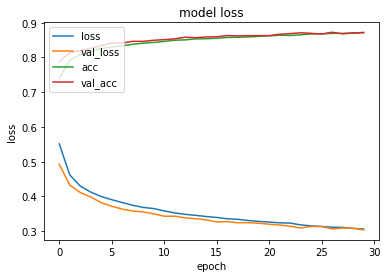

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss', 'acc', 'val_acc'], loc='upper left')
plt.show()

# PREDICT TEST DATA

In [30]:
model.evaluate(test_generator)

316/316 [==============================] - 21s 67ms/step - loss: 0.3028 - acc: 0.8717


[0.3028330216773703, 0.87168425]